# Decision Trees for Big Data Analytics

*Wannes Meert, Hendrik Blockeel, KU Leuven, 2023*

Examples based on [KU Leuven course Machine Learning and Inductive Inference (Hendrik Blockeel)](https://onderwijsaanbod.kuleuven.be/syllabi/e/H02C1AE.htm#activetab=doelstellingen_idp50160), [scikit-learn documentation](https://scikit-learn.org/stable/index.html) and [pandas documentation](http://pandas.pydata.org).

## Part 2: Decision Trees and How To Learn Them -- Classification Trees

### Setup

Set the path where the notebooks are located. If the printed path is incorrect, change the code.

In [12]:
import sys
from pathlib import Path
nb_path = Path(".")
print(f"Path to notebooks: {nb_path.absolute()}")
if not nb_path.exists():
    print("Path does not exist, update path in code")

Path to notebooks: /Users/wannes/Nextcloud/Documents/Events/2023/2023-KTU-BigDataSchool/KTU_BigDataSchool_Meert_Exercises/Notebooks


In [13]:
import numpy as np
import pandas as pd
import sklearn as sk

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

### Entropy

Before learning a decision tree, let's first look at the concept of entropy. We will use the entropy function availablein the SciPy library.

In [15]:
from scipy.stats import entropy

#### Example 1

How many bits are required to optimally encode a set of values? We can compute this based on the (normalized) histogram of values. Assume we have four symbols, {A, B, C, D}, that are all equally likely, thus 0.25, in a given message:

In [16]:
dist = [0.25, 0.25, 0.25, 0.25]
entropy(dist, base=2)

2.0

Now assume A appears 50% the time, B, 30% and C and D both 10%:

In [17]:
dist = [0.50, 0.30, 0.10, 0.10]
entropy(dist, base=2)

1.6854752972273344

In this latter case, we can encode the a message with less bytes: on average 1.7 bytes per symbol.

#### Example 2: Drinks

Let us now compute the drinks example from the lecture. We begin by loading the drinks dataset:

In [18]:
drinks_data = pd.read_csv(str(nb_path / "rsrc" / "drinks.csv"))
drinks_data

,Shape,Color,Content,Sick
0,Cilinder,Orange,25cl,0
1,Cilinder,Black,25cl,0
2,Coupe,White,10cl,0
3,Trapezoid,Green,15cl,0
4,Coupe,Yellow,15cl,0
5,Trapezoid,Orange,15cl,1
6,Coupe,Orange,15cl,1
7,Coupe,Orange,10cl,1


The dataset (and thus the root node of the decision tree) has the following entropy:

In [19]:
entr_root = entropy(drinks_data["Sick"].value_counts(), base=2)
entr_root

0.954434002924965

Suppose we split on whether the shape is a cilinder or not:

In [20]:
split_left = drinks_data.loc[drinks_data["Shape"] == "Cilinder"]
split_right = drinks_data.loc[drinks_data["Shape"] != "Cilinder"]

The instances that are sorted in the left branch:

In [21]:
split_left

,Shape,Color,Content,Sick
0,Cilinder,Orange,25cl,0
1,Cilinder,Black,25cl,0


The instances sorted in the right branch are:

In [22]:
split_right

,Shape,Color,Content,Sick
2,Coupe,White,10cl,0
3,Trapezoid,Green,15cl,0
4,Coupe,Yellow,15cl,0
5,Trapezoid,Orange,15cl,1
6,Coupe,Orange,15cl,1
7,Coupe,Orange,10cl,1


The entropies in the left and right branches are:

In [23]:
entr_left = entropy(split_left["Sick"].value_counts(), base=2)
entr_right = entropy(split_right["Sick"].value_counts(), base=2)
entr_left, entr_right

(0.0, 1.0)

#### Example 3: Tennis

We can do the same thing for the tennis example from the lecture:

In [24]:
tennis_data = pd.read_csv(str(nb_path / "rsrc" / "tennis.csv"))
tennis_data

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [25]:
entr_root = entropy(tennis_data["play"].value_counts(), base=2)
entr_root

0.940285958670631

Try to split in humidity:

In [26]:
split_left = tennis_data.loc[tennis_data["humidity"] == "high"]
split_right = tennis_data.loc[tennis_data["humidity"] != "high"]

In [27]:
entr_left = entropy(split_left["play"].value_counts(), base=2)
entr_right = entropy(split_right["play"].value_counts(), base=2)
entr_left, entr_right

(0.9852281360342515, 0.5916727785823274)

Given all entropies, we can also compute the gain that would be achieved by splitting the dataset this way:

In [28]:
gain = entr_root - len(split_left)/len(tennis_data)*entr_left - len(split_right)/len(tennis_data)*entr_right
gain

0.15183550136234159

### Building a decision tree for two dimensial example

Let's now build an actual decision tree. We will use the scikit-learn Decision Tree Classifier for this. The dataset is the two dimensional dataset shown in the lecture:

In [29]:
from sklearn import tree
import graphviz

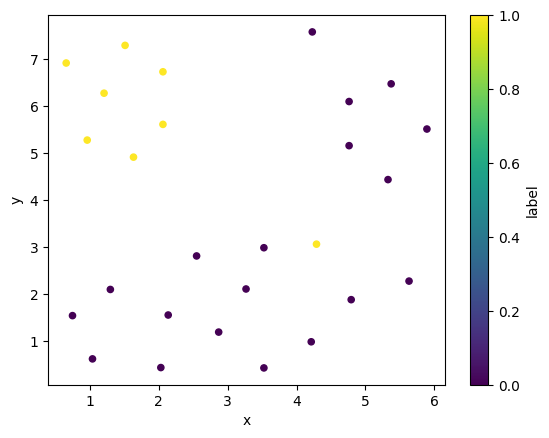

In [30]:
twodim_data = pd.read_csv(str(nb_path / "rsrc" / "twodim.csv"))
twodim_data.plot.scatter(x='x', y='y', c='label', colormap='viridis');

In [31]:
X = twodim_data[["x", "y"]].values
y = twodim_data["label"].values

Learn a decision tree by using the `fit` method:

In [32]:
clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=1)
clf.fit(X, y);

Once a classifier is learned, we can use it to predict a given set of instances. For example, again the training data:

In [33]:
clf.predict(X)

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

For two-dimensional data we can also nicely visualize the decision surfaces of this classifier:

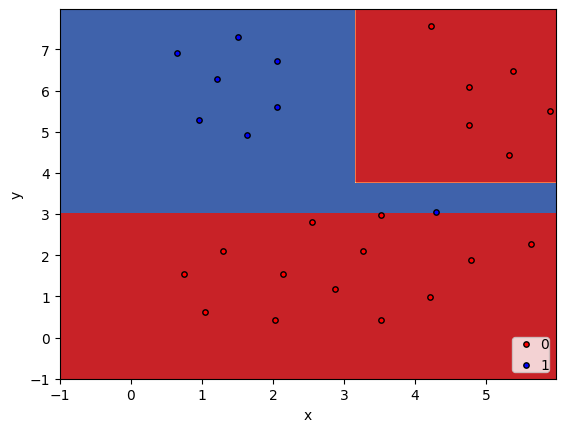

In [34]:
n_classes = 2
plot_colors = "rby"

xx, yy = np.meshgrid(np.arange(-1, 6, 0.02),
                     np.arange(-1, 8, 0.02))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel("x")
plt.ylabel("y")

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=i,
                edgecolor='black', s=15)

# plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight");

By playing with the settings given to the decision tree classifier you will see that the decision surfaces change accordingly.

Visualise the decision tree:

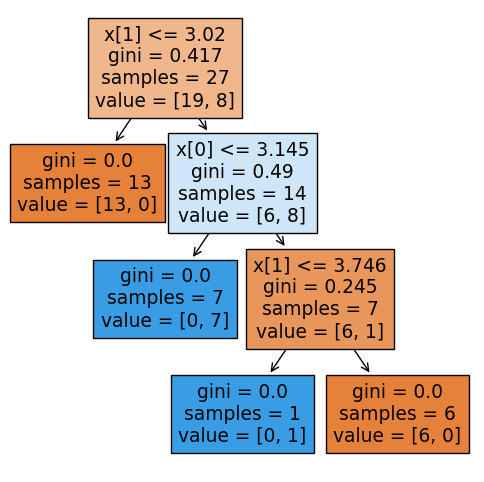

In [35]:
plt.figure(figsize=(6,6))
tree.plot_tree(clf, filled=True);

Reading the scikit-learn visualisation is done as follows:

- The first line is the test. If `feature_names` is given it is the actual name of the feature, otherwise it is the column index of the feature in the instances matrix X.
- The second line is the type of impurity test used and its value.
- The third line shows how many instances (or samples) were directed into this branch.
- The fourth line shows a histogram of the classes (for classification). Here it is two values representing the counts for class 0 and class 1.

### Building a decision tree for the Iris data set

We can also use a decision tree for a dataset with multiple features:

In [36]:
from sklearn.datasets import load_iris

In [37]:
iris = load_iris()

In [38]:
clf = tree.DecisionTreeClassifier()
clf.fit(iris.data, iris.target);

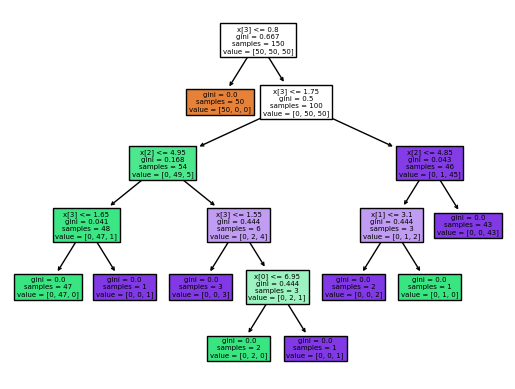

In [39]:
tree.plot_tree(clf, filled=True);

It is also possible to export the tree to the Graphiz dot format and/or to supply more information to make the nodes more informative:

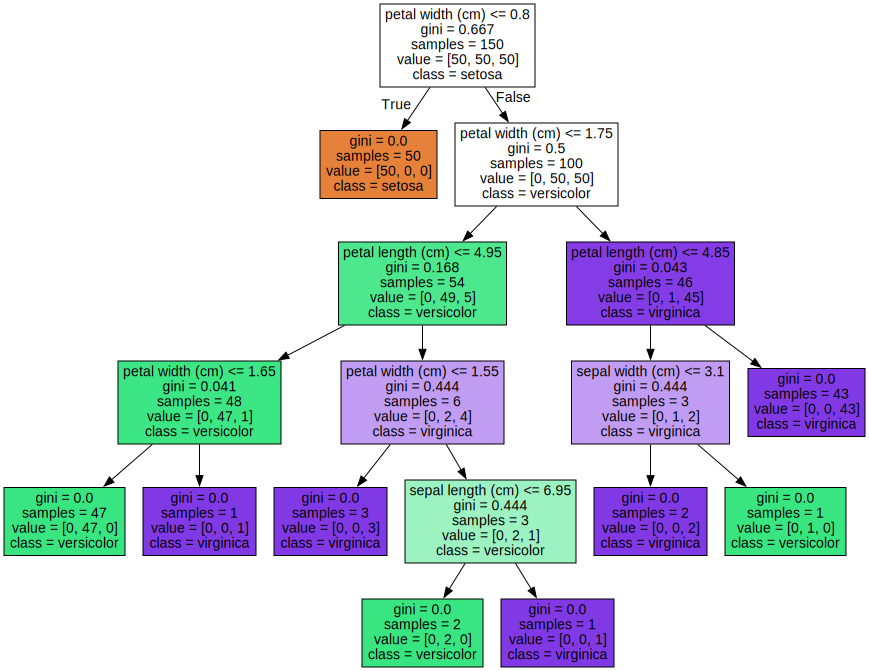

In [40]:
dot = tree.export_graphviz(clf, out_file=None,
                           feature_names=iris.feature_names,
                           class_names=iris.target_names,
                           filled=True)
graphviz.Source(dot)

We can not plot the decision surfaces in one two-dimensional plot. But we can plot the decision surface for all pairwise combinations of the input features:

In [41]:
import itertools

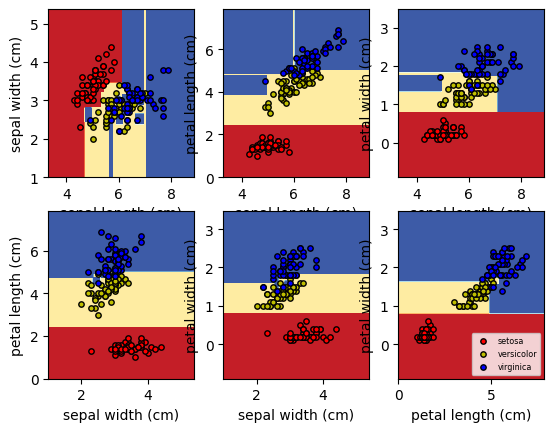

In [42]:
# Parameters
n_classes = 3
plot_colors = "ryb"
plot_step = 0.02

y = iris.target

for pairidx, pair in enumerate(itertools.combinations([0,1,2,3], 2)):
    X = iris.data[:, pair]
    clf = tree.DecisionTreeClassifier().fit(X, y)

    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])

    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    edgecolor='black', s=15)

plt.legend(loc='lower right', fontsize='xx-small');

#### Building a decision tree for a diagonal decision surface

A decision tree can only split a space along its axises. In this example, we show how a decision tree behaves when the actual decision surface is diagonal.

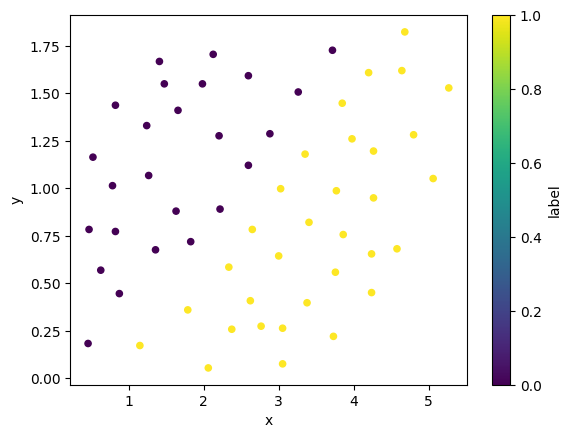

In [43]:
diagonal_data = pd.read_csv(str(nb_path / "rsrc" / "diagonal.csv"))
diagonal_data.plot.scatter(x='x', y='y', c='label', colormap='viridis');

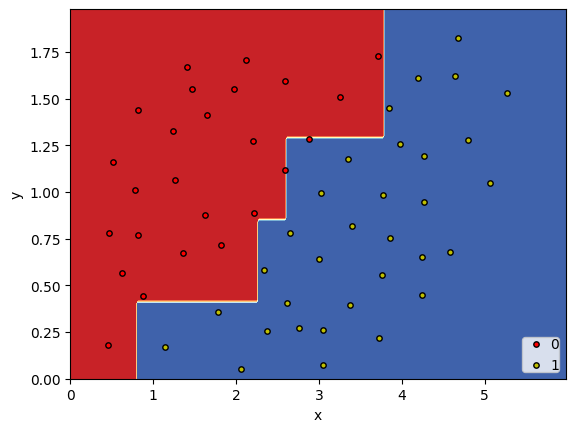

In [44]:
X = diagonal_data[["x", "y"]].values
y = diagonal_data["label"].values

clf = tree.DecisionTreeClassifier(max_depth=6, min_samples_leaf=1)
clf.fit(X, y);

n_classes = 2
plot_colors = "ryb"

xx, yy = np.meshgrid(np.arange(0, 6, 0.02),
                     np.arange(0, 2, 0.02))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel("x")
plt.ylabel("y")

# Plot the training points
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1], c=color, label=i,
                edgecolor='black', s=15)

# plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
plt.axis("tight");

If you play with the tree depth you can see that a diagonal requires a sufficient deep tree.

### Effect of depth

The depth of the tree and the minimal leaf size define how detailed the tree can be. There is typically a trade-off between not detailed enough (underfitting) and too detailed (overfitting). This is why a validation or test set is used to validate results. When the tree is too detailed it learns the exact instances in the dataset instead of the generalized pattern. Accuracy will then go up for the training set but down for the test set. This is visualized in the following example.

In [45]:
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [46]:
np.random.seed(0)
# data = load_digits(n_class=10)
# X, y = data.data, data.target
X, y = make_moons(n_samples=1000, noise=0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Deep trees with few instances in the leafs will overfit the distribution. Shallow trees with many instances, on the other hand, will underfit the distribution.

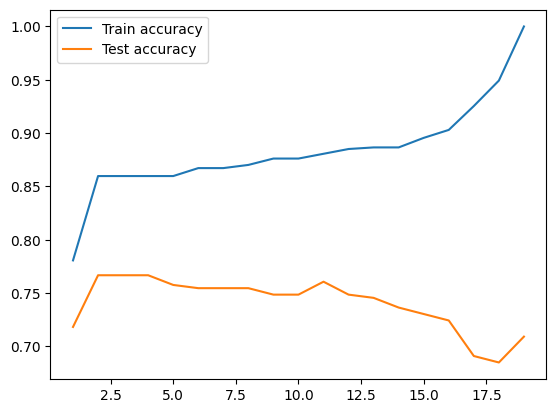

In [47]:
acc_train = []
acc_test = []
final_max_depth = 20
max_depths = list(range(1, final_max_depth))
for max_depth in max_depths:
    clf = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=final_max_depth-max_depth)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    acc_train.append(accuracy_score(y_train, y_pred))
    y_pred = clf.predict(X_test)
    acc_test.append(accuracy_score(y_test, y_pred))

plt.plot(max_depths, acc_train, label="Train accuracy")
plt.plot(max_depths, acc_test, label="Test accuracy")
plt.legend();

Notice that the train accuracy goes up to 1.0. It perfectly learns the distribution. But this is because the tree is now so complex it represents every single instances explicitly. Take a look a the decision surfaces and how peculiar they are.

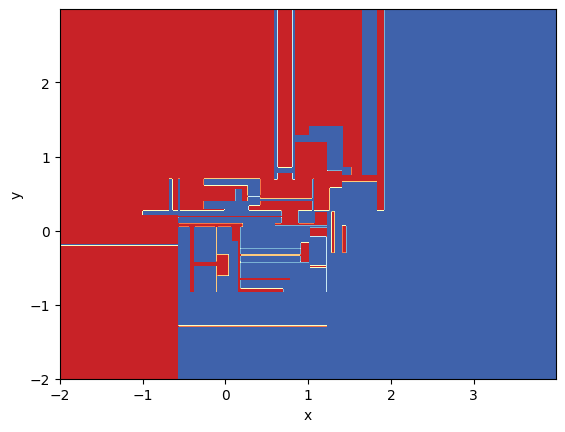

In [48]:
n_classes = 2
plot_colors = "ryb"

xx, yy = np.meshgrid(np.arange(-2, 4, 0.01),
                     np.arange(-2, 3, 0.01))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

plt.xlabel("x")
plt.ylabel("y");

# Plot the training points
# for i, color in zip(range(n_classes), plot_colors):
#     idx = np.where(y == i)
#     plt.scatter(X[idx, 0], X[idx, 1], c=color, label=i,
#                 cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

# plt.suptitle("Decision surface of a decision tree using paired features")
# plt.legend(loc='lower right', borderpad=0, handletextpad=0)

### Optional: Representation Power of a Tree

A decision tree is a tree with in each node a test. A data instances follows that path through the tree for which the tests are tree for that instance.

We will start with a simple manual decision tree builder based on scikit-learn. The manual decision tree builder is included in the resources directory for this notebook:

In [49]:
rsrc_path = nb_path / "rsrc"
lectutil_path = rsrc_path / "DTAILectureUtilities"
if not lectutil_path.exists():
    print(f"Path not found: {lectutil_path.canonical()}")
sys.path.append(str(rsrc_path))

In [50]:
from DTAILectureUtilities import manualdecisiontree

As an example we will build a decision tree that represents the OR function between X1 and X2. Note that scikit-learn requires all features to be represented by numbers. We will use 0 for false and 1 for true.

In [51]:
mytree = manualdecisiontree.DecisionTreeClassifier()
x1f, x1t = mytree.root.add_test("X1", 0)
x2f, x2t = x1f.add_test("X2", 0)
x1t.set_class(1)
x2t.set_class(1)
x2f.set_class(0)

We can visualize this classifier using the scikit-learn visualisation tools:

In [52]:
from sklearn import tree
import graphviz

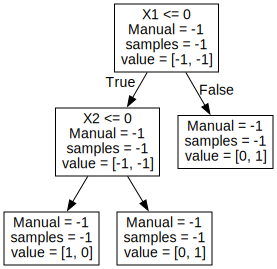

In [53]:
dot = tree.export_graphviz(mytree, out_file=None,
                           feature_names=mytree.feature_names(),
                           class_names=["false", "true"])
graphviz.Source(dot)

Reading the scikit-learn visualisation is done as follows:

- The first line is the test. If `feature_names` is given it is the actual name of the feature, otherwise it is the column index of the feature in the instances matrix.
- The second line is the type of impurity test used and its value (here empty).
- The third line shows how many instances (or samples) were directed into this branch.
- The fourth line shows a histogram of the classes (for classification). Here it is two values representing the counts for class 0/false and class 1/true.

We can test the classifier by creating an exhaustive set of instances that range over all possible combinations of X1 and X2 and having the classifier predict the outcome:

In [54]:
from itertools import product
x1x2 = np.array(list(product([0, 1], repeat=2)))
c = mytree.predict(x1x2)
for instance, prediction in zip(x1x2, c):
    print(f"{instance} -> {prediction}")

[0 0] -> 0.0
[0 1] -> 1.0
[1 0] -> 1.0
[1 1] -> 1.0
